[2024-03-04 과제]

- 이미지 이진 분류/다중 분류
- 데이터셋 : MNIST
- [조건1] 모델 성능지표 분석
- [조건2] 이미지 생성 후 predict까지 진행
-   
- logistic, SGD로 분류 2가지 해보기
- score로 과대적합/과소적합 판단
- 분류 성능 지표 확인하기
- 회귀 테스트 그림판에 직접 그려서 predict까지 해보기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.multiclass import OneVsRestClassifier

In [2]:
#mnist = fetch_openml('mnist_784')
mnist = fetch_openml('mnist_784', as_frame = False)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
# X

In [6]:
# y

In [7]:
#X.shape

In [8]:
#y.shape

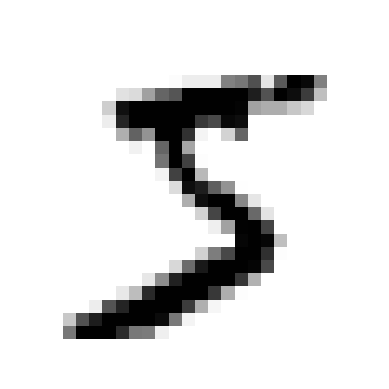

In [9]:
# 데이터셋에서 이미지 1개를 확인해보자

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap = 'binary')
    plt.axis('off')
    
some_digit = X[0]
plot_digit(some_digit)
plt.show()

### 훈련용 데이터셋, 테스트용 데이터셋 분리

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
print(f"[훈련용] X_train : {X_train.shape}        y_train : {y_train.shape}")
print(f"[테스트용] X_test : {X_test.shape}         y_test : {y_test.shape}")

[훈련용] X_train : (60000, 784)        y_train : (60000,)
[테스트용] X_test : (10000, 784)         y_test : (10000,)


### 학습 => 이진 분류 - SGD

In [13]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
print(f"train score : {sgd_clf.score(X_train, y_train_5)}")
print(f"test score : {sgd_clf.score(X_test, y_test_5)}")

train score : 0.9522666666666667
test score : 0.9492


0.01 차이로 최적 적합이다.

In [16]:
some_digit = X[0]
sgd_clf.predict([some_digit])

array([ True])

array([False])

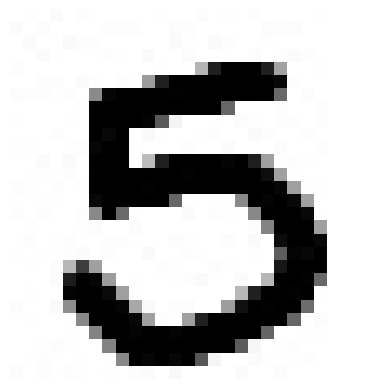

In [17]:
from PIL import Image
import numpy as np

def plot_digit(image):
    plt.imshow(image, cmap = 'binary')
    plt.axis('off')
    
path = 'digit_5.jpg'
img = Image.open(path) #그림파일 열기
img = img.convert('L') #그레이스케일로 변경
img = np.array(img)    #ndarray 로 변환
# 흑백이 반전되는 이슈가 발생함

img = abs(img.astype('int')-255) 
# img를 int로 반환하고 흑백을 원래대로 반전시키기 위해 - 255 한 후 절대값 취하였음

plot_digit(img) #크기 조정에서 문제 발생




img_array = np.append(img[0], img[1])
for i in range(2,28):
    img_array = np.append(img_array, img[i])
    #print(len(img_array))
    
    
    
    
some_digit = img_array
sgd_clf.predict([some_digit])

# 정확히 예측되었다! 그림은 8이었는데 False가 떴다는건 입력된 사진이 5가 아니다 라는 것
# 그러나 내가 그린 5 jpg 파일로 했는데도 False가 뜬다. ...ㅜ

### 성능 측정

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [19]:
# 교차 검증 구현

skfolds = StratifiedKFold(n_splits = 3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [20]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [21]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(dummy_clf.predict(X_train))

[False False False ... False False False]


In [22]:
cross_val_score(dummy_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.90965, 0.90965, 0.90965])

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [25]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [26]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [27]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [29]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-4536.59879675])

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [31]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [32]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

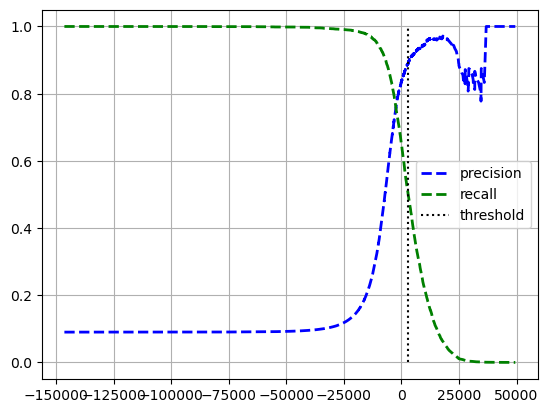

In [33]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision', linewidth = 2)
plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall', linewidth = 2)
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label = 'threshold')
plt.legend()
plt.grid(visible = True)
plt.show()

### 그림판에서 새로운 숫자 그려서 해보기

In [34]:
#print(img)